In [1]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

import keras
from keras.datasets import mnist

# Load the MNIST data.
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

# If subtract pixel mean is enabled
x_train_mean = np.mean(x_train, axis=0)
x_train -= x_train_mean
x_test -= x_train_mean

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

# Input image dimensions.
input_shape = x_train.shape[1:]

Using TensorFlow backend.


In [2]:
from keras.layers import *
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from model import LogGaussMF


def lenet_backend(input_shape):
    inputs = Input(shape=input_shape)
    c1 = Conv2D(filters=6, kernel_size=5, activation="relu")(inputs)
    s2 = AveragePooling2D(pool_size=2)(c1)
    c3 = Conv2D(filters=16, kernel_size=5, activation="relu")(s2)
    s4 = AveragePooling2D(pool_size=2)(c3)
    c5 = Dense(120, activation="relu")(Flatten()(s4))
    return inputs, c5

model_type = "LeNet"

save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = "%s_model.{epoch:03d}.h5" % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

checkpoint = ModelCheckpoint(
    filepath=filepath,
    monitor='val_acc',
    verbose=1,
    save_best_only=True)

inputs, c5 = lenet_backend(input_shape=input_shape)
f6 = Dense(84, activation="relu")(c5)
f7 = Dense(10, activation="softmax")(f6)
model = Model(inputs=inputs, outputs=f7)

model.compile(
    optimizer="adam",
    loss='categorical_crossentropy',
    metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 6)         156       
_________________________________________________________________
average_pooling2d_1 (Average (None, 12, 12, 6)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 16)          2416      
_________________________________________________________________
average_pooling2d_2 (Average (None, 4, 4, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 120)               30840     
__________

In [3]:
history = model.fit(
    x=x_train, y=y_train,
    validation_data=(x_test, y_test),
    epochs=30,
    batch_size=32,
    verbose=1, 
    callbacks=[checkpoint])

Train on 60000 samples, validate on 10000 samples
Epoch 1/30
60000/60000 [==============================] - 11s 182us/step - loss: 0.2201 - acc: 0.9336 - val_loss: 0.0775 - val_acc: 0.9744

Epoch 00001: val_acc improved from -inf to 0.97440, saving model to /home/ryan-desktop/Documents/research-2019/mnist/saved_models/LeNet_model.001.h5
Epoch 2/30
60000/60000 [==============================] - 9s 144us/step - loss: 0.0702 - acc: 0.9781 - val_loss: 0.0516 - val_acc: 0.9833

Epoch 00002: val_acc improved from 0.97440 to 0.98330, saving model to /home/ryan-desktop/Documents/research-2019/mnist/saved_models/LeNet_model.002.h5
Epoch 3/30
60000/60000 [==============================] - 9s 142us/step - loss: 0.0490 - acc: 0.9845 - val_loss: 0.0413 - val_acc: 0.9855

Epoch 00003: val_acc improved from 0.98330 to 0.98550, saving model to /home/ryan-desktop/Documents/research-2019/mnist/saved_models/LeNet_model.003.h5
Epoch 4/30
60000/60000 [==============================] - 9s 143us/step - loss:

In [4]:
model_type = "Fuzzy-LeNet"

save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = "%s_model.{epoch:03d}.h5" % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

checkpoint = ModelCheckpoint(
    filepath=filepath,
    monitor='val_acc',
    verbose=1,
    save_best_only=True)


inputs, c5 = lenet_backend(input_shape=input_shape)
memberships = LogGaussMF(10)(c5)
rules = Lambda(lambda x: K.sum(x, axis=-1))(memberships)
linear = Dense(10)(c5)
logits = Add()([rules, linear])
outputs = Activation("softmax")(logits)
model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer="adam",
    loss='categorical_crossentropy',
    metrics=['accuracy'])

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 24, 24, 6)    156         input_2[0][0]                    
__________________________________________________________________________________________________
average_pooling2d_3 (AveragePoo (None, 12, 12, 6)    0           conv2d_3[0][0]                   
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 8, 8, 16)     2416        average_pooling2d_3[0][0]        
__________________________________________________________________________________________________
average_po

In [5]:
fuzzy_history = model.fit(
    x=x_train, y=y_train,
    validation_data=(x_test, y_test),
    epochs=30,
    batch_size=32,
    verbose=1, 
    callbacks=[checkpoint])

Train on 60000 samples, validate on 10000 samples
Epoch 1/30
60000/60000 [==============================] - 9s 157us/step - loss: 0.2044 - acc: 0.9382 - val_loss: 0.0796 - val_acc: 0.9745

Epoch 00001: val_acc improved from -inf to 0.97450, saving model to /home/ryan-desktop/Documents/research-2019/mnist/saved_models/Fuzzy-LeNet_model.001.h5
Epoch 2/30
60000/60000 [==============================] - 9s 151us/step - loss: 0.0656 - acc: 0.9793 - val_loss: 0.0511 - val_acc: 0.9830

Epoch 00002: val_acc improved from 0.97450 to 0.98300, saving model to /home/ryan-desktop/Documents/research-2019/mnist/saved_models/Fuzzy-LeNet_model.002.h5
Epoch 3/30
60000/60000 [==============================] - 9s 153us/step - loss: 0.0470 - acc: 0.9853 - val_loss: 0.0460 - val_acc: 0.9854

Epoch 00003: val_acc improved from 0.98300 to 0.98540, saving model to /home/ryan-desktop/Documents/research-2019/mnist/saved_models/Fuzzy-LeNet_model.003.h5
Epoch 4/30
60000/60000 [==============================] - 9s 1

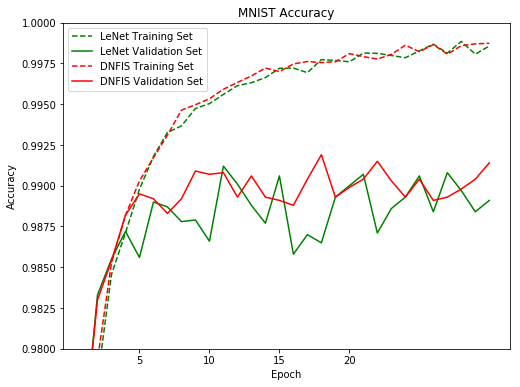

In [6]:
plt.figure(figsize=(8,6))

ax1, = plt.plot(history.history["acc"], "g--")
ax2, = plt.plot(history.history["val_acc"], "g")
ax3, = plt.plot(fuzzy_history.history["acc"], "r--")
ax4, = plt.plot(fuzzy_history.history["val_acc"], "r")

plt.title("MNIST Accuracy")

plt.xlabel("Epoch")
plt.xticks([4, 9, 14, 19], [5, 10, 15, 20])

plt.ylabel("Accuracy")
plt.ylim(0.98, 1.)

plt.legend(
    [ax1, ax2, ax3, ax4],
    ["LeNet Training Set", 
     "LeNet Validation Set",
     "DNFIS Training Set",
     "DNFIS Validation Set"])

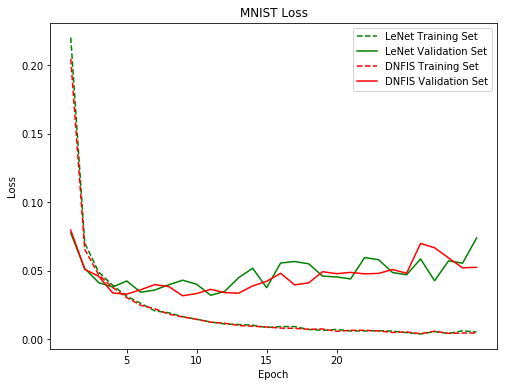

In [7]:
plt.figure(figsize=(8,6))

ax1, = plt.plot(history.history["loss"], "g--")
ax2, = plt.plot(history.history["val_loss"], "g")
ax3, = plt.plot(fuzzy_history.history["loss"], "r--")
ax4, = plt.plot(fuzzy_history.history["val_loss"], "r")

plt.title("MNIST Loss")

plt.xlabel("Epoch")
plt.xticks([4, 9, 14, 19], [5, 10, 15, 20])

plt.ylabel("Loss")

plt.legend(
    [ax1, ax2, ax3, ax4],
    ["LeNet Training Set", 
     "LeNet Validation Set",
     "DNFIS Training Set",
     "DNFIS Validation Set"])